<a href="https://colab.research.google.com/github/anudeepreddylingamolla/image-generation/blob/main/ImageGeneration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [61]:
project_name = 'augumentation'

In [147]:
!pip install opendatasets


In [63]:
import opendatasets as od

dataset_url = 'https://www.kaggle.com/datasets/tolgadincer/labeled-chest-xray-images'
od.download(dataset_url)

Skipping, found downloaded files in "./labeled-chest-xray-images" (use force=True to force download)


In [64]:
import os

DATA_DIR = './labeled-chest-xray-images'
print(os.listdir(DATA_DIR))

['chest_xray']


In [148]:
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as T

In [66]:
image_size = 64
batch_size = 128
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

In [67]:
train_ds = ImageFolder(DATA_DIR, transform=T.Compose([
    T.Resize(image_size),
    T.CenterCrop(image_size),
    T.ToTensor(),
    T.Normalize(*stats)]))

train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=3, pin_memory=True)

In [68]:
import torch
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
%matplotlib inline

In [69]:
def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]

In [70]:
def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))

def show_batch(dl, nmax=64):
    for images, _ in dl:
        show_images(images, nmax)
        break

In [71]:
!pip install jovian --upgrade --quiet

In [72]:
import jovian

In [73]:
jovian.commit(project=project_name, environment=None)

[jovian] Detected Colab notebook...
[jovian] jovian.commit() is no longer required on Google Colab. If you ran this notebook from Jovian, 
then just save this file in Colab using Ctrl+S/Cmd+S and it will be updated on Jovian. 
Also, you can also delete this cell, it's no longer necessary.


In [74]:
def get_default_device():

    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device):

    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():

    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):

        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):

        return len(self.dl)

In [75]:
device = get_default_device()
device

device(type='cuda')

In [76]:
train_dl = DeviceDataLoader(train_dl, device)

In [77]:
import torch.nn as nn

In [78]:
discriminator = nn.Sequential(
    nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),
    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),


    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),

    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),


    nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),


    nn.Flatten(),
    nn.Sigmoid())

In [104]:
discriminator = to_device(discriminator, device)

In [103]:
latent_size = 128

In [105]:
generator = nn.Sequential(


    nn.ConvTranspose2d(latent_size, 512, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),


    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),


    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),


    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),


    nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh()

)

torch.Size([128, 3, 64, 64])


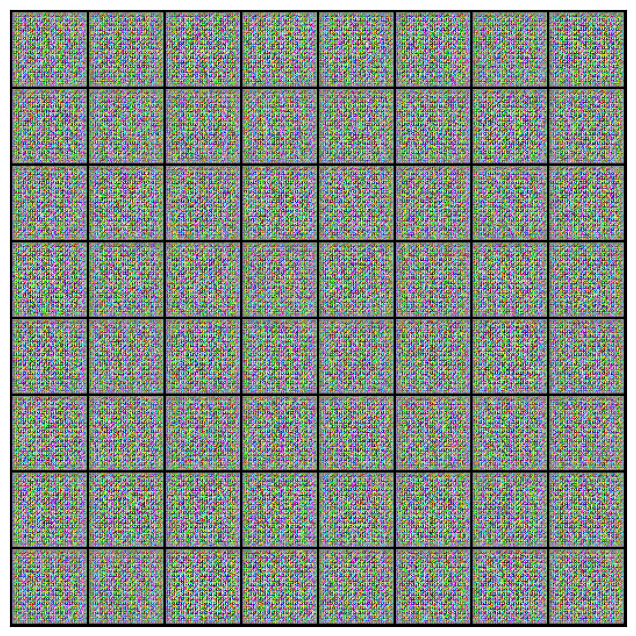

In [106]:
xb = torch.randn(batch_size, latent_size, 1, 1)
fake_images = generator(xb)
print(fake_images.shape)
show_images(fake_images)

In [107]:
generator = to_device(generator, device)

In [108]:
def train_discriminator(real_images, opt_d):

    opt_d.zero_grad()


    real_preds = discriminator(real_images)
    real_targets = torch.ones(real_images.size(0), 1, device=device)
    real_loss = F.binary_cross_entropy(real_preds, real_targets)
    real_score = torch.mean(real_preds).item()


    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)


    fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
    fake_preds = discriminator(fake_images)
    fake_loss = F.binary_cross_entropy(fake_preds, fake_targets)
    fake_score = torch.mean(fake_preds).item()


    loss = real_loss + fake_loss
    loss.backward()
    opt_d.step()
    return loss.item(), real_score, fake_score

In [109]:
def train_generator(opt_g):

    opt_g.zero_grad()

    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)

    preds = discriminator(fake_images)
    targets = torch.ones(batch_size, 1, device=device)
    loss = F.binary_cross_entropy(preds, targets)

    loss.backward()
    opt_g.step()

    return loss.item()

In [110]:
from torchvision.utils import save_image

In [111]:
sample_dir = 'generated'
os.makedirs(sample_dir, exist_ok=True)

In [112]:
def save_samples(index, latent_tensors, show=True):
    fake_images = generator(latent_tensors)
    fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
    print('Saving', fake_fname)
    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))

In [113]:
fixed_latent = torch.randn(64, latent_size, 1, 1, device=device)

Saving generated-images-0000.png


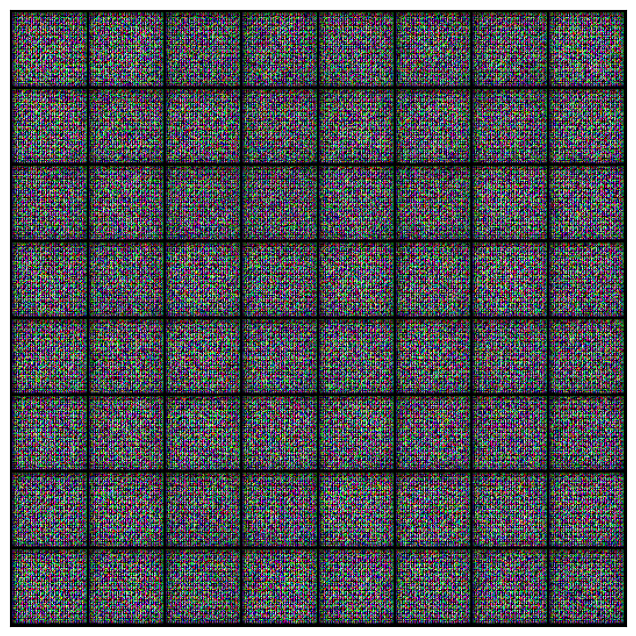

In [114]:
save_samples(0, fixed_latent)

In [115]:
jovian.commit(project=project_name, environment=None)

[jovian] Detected Colab notebook...
[jovian] jovian.commit() is no longer required on Google Colab. If you ran this notebook from Jovian, 
then just save this file in Colab using Ctrl+S/Cmd+S and it will be updated on Jovian. 
Also, you can also delete this cell, it's no longer necessary.


In [116]:
from tqdm.notebook import tqdm
import torch.nn.functional as F

In [117]:
def fit(epochs, lr, start_idx=1):
    torch.cuda.empty_cache()

    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []

    opt_d = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
    opt_g = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))

    for epoch in range(epochs):
        for real_images, _ in tqdm(train_dl):

            loss_d, real_score, fake_score = train_discriminator(real_images, opt_d)

            loss_g = train_generator(opt_g)


        losses_g.append(loss_g)
        losses_d.append(loss_d)
        real_scores.append(real_score)
        fake_scores.append(fake_score)

        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch+1, epochs, loss_g, loss_d, real_score, fake_score))

        save_samples(epoch+start_idx, fixed_latent, show=False)

    return losses_g, losses_d, real_scores, fake_scores

In [138]:
lr = 0.0002
epochs = 30

In [139]:
jovian.reset()
jovian.log_hyperparams(lr=lr, epochs=epochs)

[jovian] Hyperparams logged.


In [140]:
history = fit(epochs, lr)

  0%|          | 0/46 [00:00<?, ?it/s]

Epoch [1/25], loss_g: 15.1174, loss_d: 0.0000, real_score: 1.0000, fake_score: 0.0000
Saving generated-images-0001.png


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch [2/25], loss_g: 16.4071, loss_d: 0.0001, real_score: 1.0000, fake_score: 0.0001
Saving generated-images-0002.png


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch [3/25], loss_g: 22.8980, loss_d: 0.0001, real_score: 0.9999, fake_score: 0.0000
Saving generated-images-0003.png


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch [4/25], loss_g: 4.5576, loss_d: 0.1023, real_score: 0.9969, fake_score: 0.0918
Saving generated-images-0004.png


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch [5/25], loss_g: 4.1544, loss_d: 0.3326, real_score: 0.8281, fake_score: 0.0418
Saving generated-images-0005.png


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch [6/25], loss_g: 4.7214, loss_d: 0.1865, real_score: 0.9763, fake_score: 0.1430
Saving generated-images-0006.png


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch [7/25], loss_g: 3.1787, loss_d: 0.5358, real_score: 0.8256, fake_score: 0.2520
Saving generated-images-0007.png


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch [8/25], loss_g: 6.5302, loss_d: 0.8738, real_score: 0.9658, fake_score: 0.5263
Saving generated-images-0008.png


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch [9/25], loss_g: 3.0940, loss_d: 0.2118, real_score: 0.9083, fake_score: 0.1022
Saving generated-images-0009.png


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch [10/25], loss_g: 3.9896, loss_d: 0.0489, real_score: 0.9851, fake_score: 0.0325
Saving generated-images-0010.png


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch [11/25], loss_g: 5.1395, loss_d: 0.2315, real_score: 0.9574, fake_score: 0.1633
Saving generated-images-0011.png


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch [12/25], loss_g: 5.9504, loss_d: 0.2712, real_score: 0.8088, fake_score: 0.0144
Saving generated-images-0012.png


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch [13/25], loss_g: 3.6023, loss_d: 0.0929, real_score: 0.9757, fake_score: 0.0645
Saving generated-images-0013.png


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch [14/25], loss_g: 3.5186, loss_d: 0.1738, real_score: 0.9284, fake_score: 0.0904
Saving generated-images-0014.png


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch [15/25], loss_g: 5.2477, loss_d: 2.6517, real_score: 0.1082, fake_score: 0.0016
Saving generated-images-0015.png


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch [16/25], loss_g: 2.9712, loss_d: 0.3617, real_score: 0.8137, fake_score: 0.1256
Saving generated-images-0016.png


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch [17/25], loss_g: 3.8408, loss_d: 0.2841, real_score: 0.9258, fake_score: 0.1726
Saving generated-images-0017.png


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch [18/25], loss_g: 3.9831, loss_d: 0.3005, real_score: 0.7887, fake_score: 0.0247
Saving generated-images-0018.png


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch [19/25], loss_g: 3.9881, loss_d: 0.1732, real_score: 0.9374, fake_score: 0.0978
Saving generated-images-0019.png


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch [20/25], loss_g: 6.7918, loss_d: 0.5455, real_score: 0.9895, fake_score: 0.3957
Saving generated-images-0020.png


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch [21/25], loss_g: 3.2300, loss_d: 0.2888, real_score: 0.8692, fake_score: 0.1243
Saving generated-images-0021.png


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch [22/25], loss_g: 3.5483, loss_d: 0.3582, real_score: 0.9222, fake_score: 0.2275
Saving generated-images-0022.png


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch [23/25], loss_g: 3.5143, loss_d: 0.2712, real_score: 0.8189, fake_score: 0.0517
Saving generated-images-0023.png


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch [24/25], loss_g: 3.3035, loss_d: 3.6346, real_score: 0.1105, fake_score: 0.0020
Saving generated-images-0024.png


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch [25/25], loss_g: 4.8719, loss_d: 0.2451, real_score: 0.9758, fake_score: 0.1885
Saving generated-images-0025.png


In [141]:
losses_g, losses_d, real_scores, fake_scores = history

In [142]:
jovian.log_metrics(loss_g=losses_g[-1],
                   loss_d=losses_d[-1],
                   real_score=real_scores[-1],
                   fake_score=fake_scores[-1])


[jovian] Metrics logged.


In [143]:

torch.save(generator.state_dict(), 'G.pth')
torch.save(discriminator.state_dict(), 'D.pth')

In [144]:
from IPython.display import Image

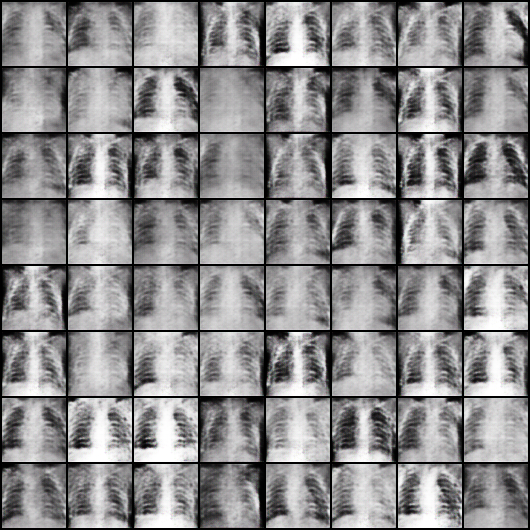

In [146]:
Image('./generated/generated-images-0025.png')